# MCTS in MCTX

In this example, we will use the `mctx` library to play the game of Connect 4.
We will implement the Monte Carlo Tree Search (MCTS) algorithm with random rollouts.

## Game mechanics

Let's start by defining some type aliases to make the code more readable.

In [1]:
import chex

# 6x7 board
# We use the following coordinate system:
#   ^
#   |
#   |
#   |
# 0 +-------->
#   0
Board = chex.Array

# Index of the column to play
Action = chex.Array

# Let's assume the game is played by players X and O.
# 1 if player X, -1 if player O
Player = chex.Array

# Reward for the player who played the action.
# 1 for winning, 0 for draw, -1 for losing
Reward = chex.Array

# True/False if the game is over
Done = chex.Array

Now, we create a class defining the game state at a given time.

In [2]:
@chex.dataclass
class Env:
    board: Board
    player: Player
    done: Done
    reward: Reward

To visualize the game state, we define a function that prints the board.

In [3]:
from rich import print

BOARD_STRING = """
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 ? | ? | ? | ? | ? | ? | ?
---|---|---|---|---|---|---
 1   2   3   4   5   6   7
"""

def print_board(board: Board):
    board_str = BOARD_STRING
    for i in reversed(range(board.shape[0])):
        for j in range(board.shape[1]):
            board_str = board_str.replace('?', '[green]X[/green]' if board[i, j] == 1 else '[red]O[/red]' if board[i, j] == -1 else ' ', 1)
    print(board_str)

Let's write a function that checks if the game is over.
We iterate over all horizontal/vertical/diagonal/anti-diagonal lines and check if there are 4 consecutive pieces of the same color.

In [4]:
import jax.numpy as jnp

def horizontals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i, j:j+4]
        for i in range(board.shape[0])
        for j in range(board.shape[1] - 3)
    ])

def verticals(board: Board) -> chex.Array:
    return jnp.stack([
        board[i:i+4, j]
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1])
    ])

def diagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def antidiagonals(board: Board) -> chex.Array:
    return jnp.stack([
        jnp.diag(board[i:i+4, j:j+4][::-1])
        for i in range(board.shape[0] - 3)
        for j in range(board.shape[1] - 3)
    ])

def get_winner(board: Board) -> Player:
    all_lines = jnp.concatenate((
        horizontals(board),
        verticals(board),
        diagonals(board),
        antidiagonals(board),
    ))
    # x_won and o_won are 1 if the player won, 0 otherwise
    x_won = jnp.any(jnp.all(all_lines == 1, axis=1)).astype(jnp.int8)
    o_won = jnp.any(jnp.all(all_lines == -1, axis=1)).astype(jnp.int8)
    # We consider the following cases:
    # - !x_won and !o_won -> 0 - 0 = 0 -> draw OR not finished
    # - x_won and !o_won -> 1 - 0 = 1 -> Player 1 (X) won
    # - !x_won and o_won -> 0 - 1 = -1 -> Player -1 (O) won
    # - x_won and o_won -> impossible, the game would have ended earlier
    return x_won - o_won

Finally, we can implement the environment dynamics:

* `env_reset` creates a brand new game
* `env_step` plays a move and returns the new state, the reward **for the player who played the move** and whether the game has ended

In [5]:
import jax.numpy as jnp

def env_reset(_):
    return Env(
        board=jnp.zeros((6, 7), dtype=jnp.int8),
        player=jnp.int8(1),
        done=jnp.bool_(False),
        reward=jnp.int8(0),
    )

You might be wondering why `env_reset` takes an unused argument.
This allows us to parallelize the environment with the `jax.vmap` function:

In [6]:
import jax

jax.vmap(env_reset)(jnp.arange(10)).player
# 10 games have been created:

2024-03-14 16:12:21.880761: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

You need to perfectly understand the `env_step` function to implement the MCTS algorithm.

In particular, you need to understand that the reward returned by `env_step` is the reward **for the player who played the move**.
This means that the reward should always be either 0 for a move that does not end the game or causes a draw, or 1 for a move that ends the game with a win for the player who played the move.

A reward of -1 is reserved for punishing illegal moves.
Since `mctx` does not support masking illegal moves below the root node, we need another way to stop the MCTS algorithm from exploring illegal moves.
Later, we will also write a custom policy function that will never select illegal moves.

In [7]:
def env_step(env: Env, action: Action) -> tuple[Env, Reward, Done]:
    col = action

    # Find the first empty row in the column.
    # If the column is full, this will be the top row.
    row = jnp.argmax(env.board[:, col] == 0)

    # If the column is full, the move is invalid.
    invalid_move = env.board[row, col] != 0

    # Place the player's piece in the board only if the move is valid and the game is not over.
    board = env.board.at[row, col].set(jnp.where(env.done | invalid_move, env.board[row, col], env.player))

    # The reward is computed as follows:
    # * 0 if the game is **already** over. This is to ignore nodes below terminal nodes.
    # * -1 if the move is invalid
    # * 1 if the move won the game for the current player
    # * 0 if the move caused a draw
    # * (impossible for Connect 4) -1 if the move lost the game for the current player
    reward = jnp.where(env.done, 0, jnp.where(invalid_move, -1, get_winner(board) * env.player)).astype(jnp.int8)

    # We end the game if:
    # * the game was already over
    # * the move won or lost the game
    # * the move was invalid
    # * the board is full (draw)
    done = env.done | reward != 0 | invalid_move | jnp.all(board[-1] != 0)

    env = Env(
        board=board,
        # switch player
        player=jnp.where(done, env.player, -env.player),
        done=done,
        reward=reward,
    )

    return env, reward, done

## The MCTS algorithm

We can now implement the MCTS algorithm.

Let's start with some helper functions.

In [8]:
def valid_action_mask(env: Env) -> chex.Array:
    '''
    Computes which actions are valid in the current state.
    Returns an array of booleans, indicating which columns are not full.
    In case the game is over, all columns are considered invalid.
    '''
    return jnp.where(env.done, jnp.array([False] * env.board.shape[1]), env.board[-1] == 0)

In [9]:
def winning_action_mask(env: Env, player: Player) -> chex.Array:
    '''
    Finds all actions that would immediately win the game for the given player.
    '''
    # Override the next player in the environment with the given player.
    env = Env(board=env.board, player=player, done=env.done, reward=env.reward)

    # Play all actions and check the reward.
    # Remember that the reward is for the current player, so we expect it to be 1.
    env, reward, done = jax.vmap(env_step, (None, 0))(env, jnp.arange(7, dtype=jnp.int8))
    return reward == 1

Next, we define a policy function. The policy function is used in two places:

* during random rollouts to select the next action to play
* during node expansion as the prior distribution

We could have used a uniform distribution for both, but we can do better.
Let's use three simple heuristics:

* never select illegal moves
* always select winning moves if available
* always block opponent's winning moves if we have no winning move

Our policy function implementation returns unnormalized logits,
so we cannot return pure 0% and 100% probabilities (using `inf` and `-inf` causes downstream numerical issues).
Instead, we add `100` to the logits of a given action which we want to prioritize:

* the lowest priority of `0` is assigned to illegal moves
* a medium priority of `100` is assigned to legal moves
* a higher priority of `200` is assigned to the opponent's winning moves
* the highest priority of `300` is assigned to our winning moves

In [10]:
def policy_function(env: Env) -> chex.Array:
    # return jnp.zeros(env.board.shape[1], dtype=jnp.float32)
    return sum((
        valid_action_mask(env).astype(jnp.float32) * 100,
        winning_action_mask(env, -env.player).astype(jnp.float32) * 200,
        winning_action_mask(env, env.player).astype(jnp.float32) * 300,
    ))

This is how these logits translate to probabilities:

In [11]:
env = env_reset(0)
env, _, _ = env_step(env, 0)
env, _, _ = env_step(env, 6)
env, _, _ = env_step(env, 0)
env, _, _ = env_step(env, 6)
env, _, _ = env_step(env, 0)
env, _, _ = env_step(env, 6)
jax.nn.softmax(policy_function(env))

Array([1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 3.8e-44],      dtype=float32)

In [11]:
jax.nn.softmax(jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

Array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715], dtype=float32)

In [13]:
jax.nn.softmax(jnp.array([100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

Array([1.0e+00, 3.8e-44, 3.8e-44, 3.8e-44, 3.8e-44, 3.8e-44, 3.8e-44],      dtype=float32)

In [12]:
jax.nn.softmax(jnp.array([100.0, 200.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

Array([3.8e-44, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],      dtype=float32)

In [14]:
jax.nn.softmax(jnp.array([100.0, 200.0, 300.0, 0.0, 0.0, 0.0, 0.0]))

Array([0.0e+00, 3.8e-44, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00],      dtype=float32)

In [15]:
jax.nn.softmax(jnp.array([100.0, 200.0, 300.0, 300.0, 0.0, 0.0, 0.0]))

Array([0.e+00, 2.e-44, 5.e-01, 5.e-01, 0.e+00, 0.e+00, 0.e+00], dtype=float32)

You can see that a difference of 100 is enough to make a move almost certain to be selected.

The MCTS algorithm uses random rollouts to estimate the value of each state.
We can implement this with a simple function that plays moves according to our policy function until the game ends.

In [12]:
def rollout(env: Env, rng_key: chex.PRNGKey) -> Reward:
    '''
    Plays a game until the end and returns the reward from the perspective of the initial player.
    '''
    def cond(a):
        env, key = a
        return ~env.done
    def step(a):
        env, key = a
        key, subkey = jax.random.split(key)
        action = jax.random.categorical(subkey, policy_function(env))
        env, reward, done = env_step(env, action)
        return env, key
    leaf, key = jax.lax.while_loop(cond, step, (env, rng_key))
    # The leaf reward is from the perspective of the last player.
    # We negate it if the last player is not the initial player.
    return leaf.reward * leaf.player * env.player

The value function is simply the result of the rollout.

In [13]:
def value_function(env: Env, rng_key: chex.PRNGKey) -> chex.Array:
    return rollout(env, rng_key).astype(jnp.float32)

## Running mctx

Finally, we get to use the `mctx` library.
We need two function:

* `root_fn` returns the root node of the MCTS tree
* `recurrent_fn` expands a new node given a parent node and an action

In [14]:
import mctx

def root_fn(env: Env, rng_key: chex.PRNGKey) -> mctx.RootFnOutput:
    return mctx.RootFnOutput(
        prior_logits=policy_function(env),
        value=value_function(env, rng_key),
        # We will use the `embedding` field to store the environment.
        embedding=env,
    )

In [15]:
def recurrent_fn(params, rng_key, action, embedding):
    # Extract the environment from the embedding.
    env = embedding

    # Play the action.
    env, reward, done = env_step(env, action)

    # Create the new MCTS node.
    recurrent_fn_output = mctx.RecurrentFnOutput(
        # reward for playing `action`
        reward=reward,
        # discount explained in the next section
        discount=jnp.where(done, 0, -1).astype(jnp.float32),
        # prior for the new state
        prior_logits=policy_function(env),
        # value for the new state
        value=jnp.where(done, 0, value_function(env, rng_key)).astype(jnp.float32),
    )

    # Return the new node and the new environment.
    return recurrent_fn_output, env

The `discount` field is used to flip the sign of the reward and value at each tree level.
It would be possible to implement this in the environment dynamics, but it is more convenient to do it here.
By flipping the sign, MCTS selects the best action for the current player of each turn.

Note that we set `discount` to `0` when the game is over.
This discards all the rewards and values after the end of the game.

And now we can run MCTS!

In [16]:
import functools

@functools.partial(jax.jit, static_argnums=(2,))
def run_mcts(rng_key: chex.PRNGKey, env: Env, num_simulations: int) -> chex.Array:
    batch_size = 1
    key1, key2 = jax.random.split(rng_key)
    policy_output = mctx.muzero_policy(
        # params can be used to pass additional data to the recurrent_fn like neural network weights
        params=None,

        rng_key=key1,

        # create a batch of environments (in this case, a batch of size 1)
        root=jax.vmap(root_fn, (None, 0))(env, jax.random.split(key2, batch_size)),

        # automatically vectorize the recurrent_fn
        recurrent_fn=jax.vmap(recurrent_fn, (None, None, 0, 0)),

        num_simulations=num_simulations,

        # we limit the depth of the search tree to 42, since we know that Connect Four can't last longer
        max_depth=42,

        # our value is in the range [-1, 1], so we can use the min_max qtransform to map it to [0, 1]
        qtransform=functools.partial(mctx.qtransform_by_min_max, min_value=-1, max_value=1),

        # Dirichlet noise is used for exploration which we don't need in this example (we aren't training)
        dirichlet_fraction=0.0,
    )
    return policy_output

Let's play the middle column two times and see what MCTS does:

[[0.072      0.238      0.193      0.11400001 0.29000002 0.066
  0.027     ]]

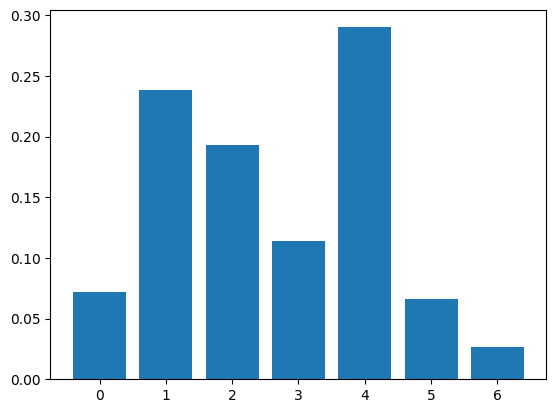

: 

In [44]:
env = env_reset(0)
env, reward, done = env_step(env, 3)
env, reward, done = env_step(env, 3)
policy_output = run_mcts(jax.random.PRNGKey(38), env, 1000)
print(policy_output.action_weights)

import matplotlib.pyplot as plt
plt.bar(jnp.arange(7), policy_output.action_weights.mean(axis=0))
plt.show()

It chose the middle column as the best move, as expected.

Let's write a simple script to play against MCTS:

In [ ]:
# set to False to enable human input
player_1_ai = True
player_2_ai = True

key = jax.random.PRNGKey(0)
env = env_reset(0)
print_board(env.board)
while True:
    if player_1_ai:
        action = run_mcts(key, env, 1000).action_weights.argmax().item()
    else:
        action = int(input()) - 1

    env, reward, done = env_step(env, action)
    print_board(env.board)
    if done: break

    if player_2_ai:
        # you can give it more simulations to make it stronger
        action = run_mcts(key, env, 1000).action_weights.argmax().item()
    else:
        action = int(input()) - 1

    env, reward, done = env_step(env, action)
    print_board(env.board)
    if done: break

players = {
    1: "[green]X[/green]",
    -1: "[red]O[/red]",
}
print(f"Winner: {players[env.player.item()]}")

In [36]:
envs = jax.vmap(env_reset)(jax.numpy.arange(128))
rng_keys = jax.random.split(jax.random.PRNGKey(0), 128)
policy_outputs = jax.vmap(run_mcts, in_axes=(0, 0, None))(rng_keys, envs, 1000)
policy_outputs.action_weights.shape


(128, 1, 7)

At `10_000` simulations, the agent was able to beat all online Connect 4 bots I could find.